# APIs

APIs são mecanismos que permitem que dois componentes de software se comuniquem usando um conjunto de definições e protocolos. Por exemplo, o sistema de software do instituto meteorológico contém dados meteorológicos diários. O aplicativo meteorológico em seu telefone “fala” com este sistema por meio de APIs e mostra atualizações meteorológicas diárias no telefone.

API significa Application Programming Interface (Interface de Programação de Aplicação). No contexto de APIs, a palavra Aplicação refere-se a qualquer software com uma função distinta. A interface pode ser pensada como um contrato de serviço entre duas aplicações. Esse contrato define como as duas se comunicam usando solicitações e respostas. A documentação de suas respectivas APIs contém informações sobre como os desenvolvedores devem estruturar essas solicitações e respostas.

![image.png](images/api.jpeg)

`client`: O cliente

`api`: O garçom

`o serviço (banco de dados, web application, twitter, spotify)`: O pizzaiolo

# Web APIs

## Some Examples

### API endpoints

**NASA API**: http://api.open-notify.org/
- http://api.open-notify.org/iss-now.json
    - Documentation: http://open-notify.org/Open-Notify-API/ISS-Location-Now/

**Meme API**

- http://apimeme.com/?ref=apilist.fun
- http://apimeme.com/meme?meme=Doge&top=Analista&bottom=de_Dados
    

**Public APIs**

- https://github.com/public-apis/public-apis

## Acessando APIs via Requests

`Requests` é uma biblioteca Python que nos permite interagir com servidores [HTTP](https://en.wikipedia.org/wiki/Hypertext_Transfer_Protocol). Essa biblioteca pode ser utilizada para baixar páginas, arquivos e **interagir com APIs**.



[Documentação - requests](https://requests.readthedocs.io)

In [ ]:
! pip3 install requests

In [ ]:
import requests, time

### Utilizando `requests`

Vamos começar acessando uma API simples que nos permite extrair, a cada 5s, a posição da [ISS](https://en.wikipedia.org/wiki/International_Space_Station).

O primeiro passo é descobrir o `endpoint` desta API. O `endpoint` é o URL através do qual acessamos uma API!

In [ ]:
endpoint = 'http://api.open-notify.org/iss-now.json'

Com nosso URL em mãos, podemos utilizar a biblioteca `requests` para extrair a informação da API:

In [ ]:
response = requests.get(endpoint)

O que é o objeto que guardamos na variável `response`?

In [ ]:
response

O objeto é do tipo `response` e ele contém o código HTTP associado ao nosso request:

![image.png](images/http_status_codes.jpeg)

Com este código podemos saber se a nossa comunicação com o servidor de certo ou não (e porque não deu certo).

https://www.tutorialspoint.com/http/http_status_codes.htm

Para extrair a informação que a API nos retornou (no caso de um sucesso), podemos utilizar o método `.json()`. 
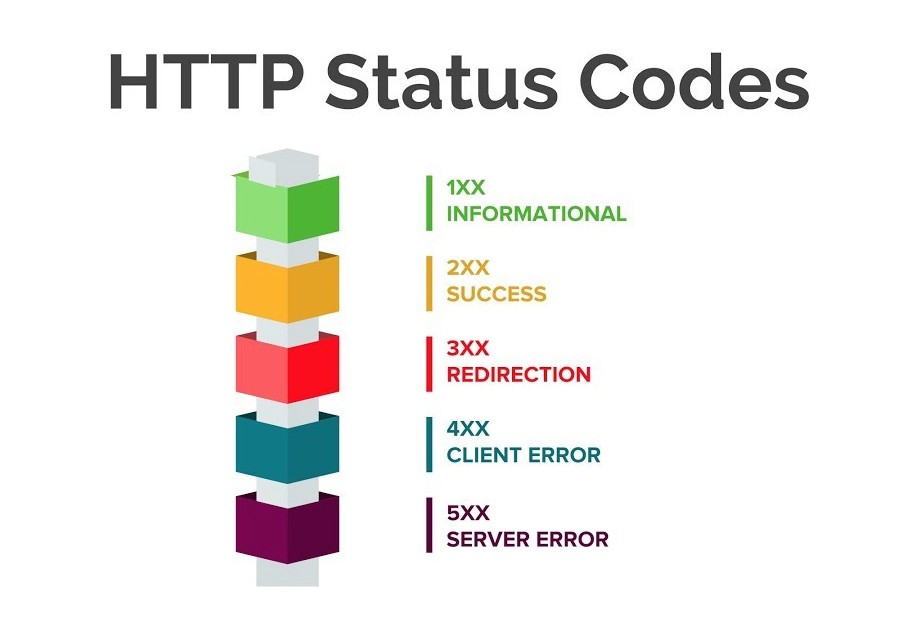

In [ ]:
response.json()

Como nosso *request* teve sucesso (status 200), o método `.json()` nos retorna o resultado como um dicionário ou uma lista:

In [ ]:
resultado = response.json()
type(resultado)

#### Erros de HTTP

Um problema comum ao construirmos scripts que acessam API é a tratativa de erros HTTP. Caso a API não retorne o que esperamos as etapas subsequentes de nosso programa podem falhar. As tratativas de erro HTTP são fundamentais em qualquer programa que tenha extraia informações (seja de uma API, seja via web-scrapping).

Vamos simular um erro tentando acessar um endpoint inexistente:

In [ ]:
response = requests.get('http://api.open-notify.org/coisas_aleatória.json')
response

Através do objeto `Response` já vemos que o status da execução não é de sucesso: 404 indica um **Client Error**. Podemos utilizar o atributo `.status_code` deste objeto para extrair o código de status diretamente:

In [ ]:
response.status_code

Poderíamos tratar os diferentes códigos de status através de condicionais. No entanto, como são muitos códigos diferentes e esta é uma tarefa muito comum, o objeto `Response` contém um método que realiza essa tratativa: `.raise_for_status()`

In [ ]:
response.raise_for_status()

O método `.raise_for_status()` *levanta* um erro toda vez que um código que não seja sucesso é retornado. Sendo assim, podemos utilizar um `try:` e `except:` para tratar este `HTTPError`!

In [ ]:
from requests import HTTPError

try:
    response = requests.get('http://api.open-notify.org/coisas_aleatória.json')
    response.raise_for_status()
    resultado = response.json()
except HTTPError as e:
    print(f'Falha na comunicação com o servidor:\n {e}')
    resultado = None

print(resultado)

Vamos comparar o resultado do bloco acima utilizando o *endpoint* real da API:

In [ ]:
try:
    response = requests.get('http://api.open-notify.org/iss-now.json')
    response.raise_for_status()
    resultado = response.json()
except HTTPError as e:
    print(f'Falha na comunicação com o servidor:\n {e}')
    resultado = None

print(resultado)

## Utilizando APIs I

Até agora vimos como podemos acessar, extrair informações e tratar erros de uma API através de métodos e funções fundamentais. Vamos utilizar este conhecimento para construir um `DataFrame` com as posições da ISS.

In [ ]:
from datetime import datetime
import pandas as pd

response = requests.get('http://api.open-notify.org/iss-now.json')
results = response.json()

A primeira etapa de qualquer construção envolvendo uma ou mais APIs é a exploração do objeto retornado.

In [ ]:
type(results)

A API da ISS retorna um dicionário: vamos analisar como este dicionário está estruturado:

In [ ]:
results.keys()

Vamos investigar como as informações estão estruturadas dentro destas chaves:

In [ ]:
for chave in results.keys():
    print(f"{chave}: {type(results[chave])}")

As chaves `message` e `timestamp` são tipos simples (`str` e `int` respectivamente). Já a chave `iss_position` é outro dicionário:

In [ ]:
results['iss_position']

O resultado desta API é muito simples - temos 3 chaves, sendo que 2 são de interesse para nós:

1. `iss_position` contém duas chaves, `latitude` e `longitude`, contendo a posição da ISS;
1. `timestamp` contém o **timestamp** associado a esta posição.

Primeiro, vamos utilizar a função `fromtimestamp()` do módulo `datetime` para converter nosso `timestamp` em um objeto `DateTime`:

In [ ]:
data_hora = datetime.fromtimestamp(results['timestamp'])
print(data_hora)

Agora que vimos como transformar este resultado, podemos construir um loop para criar uma tabela com a posição da ISS a cada 10s, por 1 minuto:

In [ ]:
lat = []
long = []
data_hora = []

for i in range(6):
    response = requests.get('http://api.open-notify.org/iss-now.json')
    results = response.json()

    lat.append(float(results['iss_position']['latitude']))
    long.append(float(results['iss_position']['longitude']))
    data_hora.append(datetime.fromtimestamp(results['timestamp']))

    time.sleep(10)

Agora vamos construir nosso `DataFrame` a partir das listas que criamos em nosso loop:

In [ ]:
tb_iss = pd.DataFrame({'lat': lat, 'long':long, 'time':data_hora})

In [ ]:
tb_iss

In [ ]:
tb_iss.info()

## Utilizando APIs II

A API da ISS é extremamente rudimentar: ela não possui nem autenticação nem parâmetros, simplesmente retorna a posição atual da ISS. Muitas APIs são mais complexas do que isso, necessitando de autenticação e possibilitando a utilização de parâmetros:

1. **Autenticação**: muitas APIs precisam que o seu programa se autentique, ou seja, se identifique. Muitas vezes isso é feito através do site que disponibiliza a API e requer a criação de um usuário;
1. **Parâmetros**: parâmetros são informações que passamos para a API utilizadas para determinar que informação será retornada.

No próximo exemplo utilizaremos a [WeatherAPI](https://www.weatherapi.com). Esta API retorna informações climáticas para um dado local. Ela é autenticada (através de um *token*) e necessita de uma parametrização (a latitude e longitude do local para o qual queremos extrair as informações).

Primeiro vamos criar especificar todos os parâmetros necessários para a consulta à esta API:

In [ ]:
token = 'bfef1b47e3b8462199b191725221801'
endpoint = 'http://api.weatherapi.com/v1/current.json'

header = {'key' : token}
query = {'q' : '-21.996160,-47.426420'}

Utilizamos dois dicionários para especificar tanto a autenticação quanto a parametrização de nosso request:

1. `header`: é um dicionário que contém apenas uma chave, `key`, na qual guardamos nosso token identificador;
1. `query`: é um dicionário que contém apenas uma chave, `q`, na qual guardamos um string de latitude e longitude.

O nome das chaves foi determinado lendo a documentação da API: https://www.weatherapi.com/docs/.

Agora vamos utilizar nossos dicionários e a função `request()` para extrair as informações metereológicas da latitude **-21,996160** e longitude **-47,426420**

In [ ]:
response = requests.request('GET', endpoint,
                            headers=header, 
                            params=query)
results = response.json()

Utilizamos o argumento `headers =` para passar ao `request()` nossos parâmetros de autenticação, e o argumento `params =` para passar os parâmetros de busca.

In [ ]:
results

Esta API é muito mais complexa que a API da ISS: não só pela autenticação e parametrização, mas também pela complexidade dos resultados retornados.

Primeiro, vamos construir uma aplicação simples cujo objetivo é guardar apenas as informações temperatura, humidade, pressão do ar e velocidade do vento. Para isso precisamos investigar o resultado retornado e determinar quais chaves iremos guardar:

In [ ]:
# EXERCICIO
# Extrair as informações de temperatura, humidade, pressão do ar e velocidade do vento 
# para a lista de latitudes e longitudes abaixo.
lista_latlong = [
    '-23.57,-46.69', 
    '-1.34,-48.60', 
    '-7.99,-34.87', 
    '6.51,3.39',
    '33.69,-84.44', 
    '69.00, 33.13'
]

### Utilizando `json_normalize()`

No exercicio acima, guardamos apenas um sub-conjunto das informações extraídas. No entanto, muitas vezes é mais prático guardar todas as informações para depois filtra-la.

Para simplificar este processo podemos utilizar a função `json_normalize()` da biblioteca Pandas.

In [ ]:
# Verificar variável response.json()
token = 'bfef1b47e3b8462199b191725221801'

endpoint = 'http://api.weatherapi.com/v1/current.json'
header = {'key' : token}
query = {'q' : '-21.99,-47.42'}


response = requests.request('GET', endpoint, headers=header, params=query)
results = response.json()
print(results)

Primeiro vamos construir um loop para percorrer uma lista de latitudes e longitudes e armazenar os dicionários de resultados em uma lista:

In [ ]:
lista_latlong = [
    '-23.57,-46.69', 
    '-1.34,-48.60', 
    '-7.99,-34.87', 
    '6.51,3.39',
    '33.69,-84.44', 
    '69.00, 33.13'
]

In [ ]:
token = 'bfef1b47e3b8462199b191725221801'
endpoint = 'http://api.weatherapi.com/v1/current.json'
header = {'key' : token}
lista_resultados = []
for latlong in lista_latlong:
    query = {'q' : latlong}
    response = requests.request('GET', endpoint, headers=header, params=query)
    results = response.json()
    lista_resultados.append(results)

A variável `lista_resultados` é uma `list` de `dicts`: cada elemento desta lista contém as informações de uma localização específica em um dicionário.

Agora, vamos utilizar a função `json_normalize()` da biblioteca `Pandas` para transformar esta lista em um `DataFrame`, onde cada linha será correspondente à cada elemento da lista:

In [ ]:
tb_weather = pd.json_normalize(lista_resultados)
tb_weather


A função transformou os dicionários hierarquicos em colunas individuais: para evitar a colisão de nomes de colunas, utilizou-se a notação de `.`: por exemplo, o sub-dicionário `location`, que contém campos relativos à localização, foi armazenado nas colunas `location.name`, `location.region`, etc...

In [ ]:
tb_weather.columns

In [ ]:
tb_weather.describe()

# Encapsulando APIs 

Muitas vezes as funções de uma API são encapsuladas em um **wrapper**: uma classe que contém todo o código necessário para autenticar e parametrizar queries em uma dada API. Vamos construir um **wrapper** para a nossa tarefa acima.

In [ ]:
class WeatherAPI:
    '''
    Wrapper para a API https://www.weatherapi.com/docs/
    '''
    def __init__(self, token):
        '''
        Inicializa o wrapper.
        token Str: Token de identificação do usuário da API
        '''
        self.header = {'key' : token}

    def query_latlong(self, lat, long):
        '''
        Busca dados meterológicos atuais para uma localização específica
        lat Float: latitude da localização
        long Float: longitude da localização
        '''
        query = {'q' : f"{lat:.4f},{long:.4f}"}
        try:
            response = requests.request('GET', endpoint, 
                                        headers=self.header, 
                                        params=query)
            response.raise_for_status()
            return response.json()
        except HTTPError as e:
            print(e)
            return None
    

In [ ]:
minha_api = WeatherAPI('bfef1b47e3b8462199b191725221801')
minha_api.query_latlong(-15, -47)